# Immigration Data Pipeline
## Udacity Data Engineering Capstone Project

### Project Summary
The purpose of this project is to create an ETL pipeline that wrangles data on immigration, demographics and environmental factors (specifically temperature), in order to be able to glean insights about what factors may make certain US destination popular for international visits. Example questions that business users may want answered include:
* Is there a correlation between a visitor's home temperature and the temperature of their chosen destination?
* Do people from certain countries prefer destination cities where certain ethnicities are better represented?
* Are particular destinations more popular with holders of visas of a certain type?

We'll be using Spark to process the data.

The project is broken down into 5 steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Clean Up the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Discussion

In [1]:
# Let's get ready by importing the libraries and tools we'll be using...

import pandas as pd
import helpers
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, upper, first, dayofmonth, weekofyear, month, year, dayofweek, udf, monotonically_increasing_id, datediff
from pyspark.sql.types import StringType

# ...and initializing our SparkSession

spark = SparkSession.builder.\
config('spark.jars.repositories', 'https://repos.spark-packages.org/').\
config('spark.jars.packages', 'saurfang:spark-sas7bdat:2.0.0-s_2.11').\
enableHiveSupport().getOrCreate()

## Step 1: Scoping the Project and Gathering Data

### Scope 
We have various data on immigration, travel, temperature and demographics, from various sources. The business need is to be able to query the data to see what factors may affect immigration or US travel destination choices. More specifically, the goal is to create a set of relational tables against which we can run queries to look for patterns between chosen immigration or travel destination, and demographic and environmental factors.

To accomplish this, Spark will be used, as it is well suited to process large amounts of data across multiple servers. If we wanted to take the project further, we could migrate the output data into a suitable RDBMS, like Redshift, and we could automate the pipleline with Airflow; this, however, is outside the scope of this particular project. The primary goal and scope of the task here is to explore the data, model it and load it into relational tables suitable for analytic querying.


### Describing and Gathering the Data 
The source data are the following:

* _I94 Immigration Data_: This data comes from the [US National Tourism and Trade Office](https://www.trade.gov/i-94-arrivals-program). It consists of the 2016 I-94 visitor arrivals data, providing information on arrivals for US visitors who stay 1 night or more. The link to the original dataset is defunct, but a copy of the data was captured and provided by Udacity.
* _World Temperature Data_: [This dataset](https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data) was sourced from Kaggle. It consists of a table of global land temperatures by city and by month, from approximately 1750.
* _U.S. City Demographic Data_: [This data](https://public.opendatasoft.com/explore/dataset/us-cities-demographics/export/) comes from OpenSoft. The data is compiled from the US Census Bureau's 2015 American Community Survey. It contains demographic information for all US cities that have a population of 65,000 or more. 
* _Airport Code Table_: [This](https://datahub.io/core/airport-codes#data) is a table of airport codes and corresponding cities.

To create the relational tables that will allows us to explore demographic and environmental correlations, we will only need data from the first three sets. We will not be using the _Airport Code Table_ dataset.

## Step 2: Exploring and Cleaning Up the Data
Let's identify data quality issues, like missing values, duplicate data, etc.

Some of this data was explored "offline", so to speak; information was gathered by visiting the original sources for the datasets or via supplemental contextual information. The i94 dataset, particularly, benefited from this; the definitions of the columns was understood primarily through looking at the `I94_SAS_Labels_Descriptions.SAS` file located in the same directory as this README file.

### Exploration
#### Immigration Data

In [2]:
# Read in the i94 data
i94_df = spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')

In [3]:
# Get a preview
i94_df.limit(5).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,None,NaN,...,U,None,1979.0,10282016,None,None,None,1.897628e+09,None,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,...,Y,None,1991.0,D/S,M,None,None,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,...,None,M,1961.0,09302016,M,None,OS,6.666432e+08,93,B2
3,16.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,None,M,1988.0,09302016,None,None,AA,9.246846e+10,00199,B2
4,17.0,2016.0,4.0,101.0,101.0,NYC,20545.0,1.0,MA,20567.0,...,None,M,2012.0,09302016,None,None,AA,9.246846e+10,00199,B2


In [4]:
# Show the total of null or NaN values per column
helpers.show_total_missing_values(i94_df)

,column name,total missing,% missing
0,cicid,0,0.000000
1,i94yr,0,0.000000
2,i94mon,0,0.000000
3,i94cit,0,0.000000
4,i94res,0,0.000000
5,i94port,0,0.000000
6,arrdate,0,0.000000
7,i94mode,239,0.007719
8,i94addr,152592,4.928184
9,depdate,142457,4.600859


#### Demographic Data

In [5]:
# Read in the demographic data
demog_df = spark.read.csv('us-cities-demographics.csv', inferSchema=True, header=True, sep=';')

In [6]:
# Get a preview
demog_df.limit(5).toPandas()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.60,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


In [7]:
# Show the total of null or NaN values per column
helpers.show_total_missing_values(demog_df)

,column name,total missing,% missing
0,City,0,0.000000
1,State,0,0.000000
2,Median Age,0,0.000000
3,Male Population,3,0.103770
4,Female Population,3,0.103770
5,Total Population,0,0.000000
6,Number of Veterans,13,0.449671
7,Foreign-born,13,0.449671
8,Average Household Size,16,0.553442
9,State Code,0,0.000000


#### Temperature Data

In [8]:
# Read in the temperature data
temp_df = spark.read.csv('../../data2/GlobalLandTemperaturesByCity.csv', header=True, inferSchema=True)

In [9]:
# Get a preview
temp_df.limit(5).toPandas()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
3,1744-02-01,NaN,NaN,Århus,Denmark,57.05N,10.33E
4,1744-03-01,NaN,NaN,Århus,Denmark,57.05N,10.33E


In [10]:
# Show the total of null or NaN values per column, but first we cast the datetime column to string
temp_df_string = temp_df.withColumn('dt', col('dt').cast(StringType()))
helpers.show_total_missing_values(temp_df_string)

,column name,total missing,% missing
0,dt,0,0.000000
1,AverageTemperature,364130,4.234458
2,AverageTemperatureUncertainty,364130,4.234458
3,City,0,0.000000
4,Country,0,0.000000
5,Latitude,0,0.000000
6,Longitude,0,0.000000


### Clean Up

#### Immigration Data
If we look again at the table of total missing values per column in the _Exploration_ section, we can see that three columns have a total of more than 85% missing values: `occup`, `entdepu`, and `insnum`. These can be dropped.

Taking this a step further, as we'll see shortly in our data model, there are only 11 columns we're interested in keeping. Let's select these to make the dataframe easier to work with and more legible to display. While we're at it, let's rename those columns and drop duplicates.

In [11]:
i94_df = i94_df.select(col('cicid').alias('id'),
                             col('i94cit').alias('citizenship_country'),
                             col('i94res').alias('residence_country'),
                             col('i94port').alias('port_of_entry'),
                             col('i94addr').alias('destination_state'),
                             col('arrdate').alias('arrival_date'),
                             col('depdate').alias('departure_date'),
                             col('i94bir').alias('age'),
                             col('i94visa').alias('visa_type'),
                             col('dtaddto').alias('admitted_until'),
                             col('gender').alias('gender')
                            ).dropDuplicates().cache()

We'll also convert the SAS dates in `arrdate` and `depdate`, and the string date in `dtaddto`, to PySpark dates.

In [12]:
i94_df = i94_df.withColumn('arrival_date', helpers.convert_sas_date_to_datetime(i94_df.arrival_date)).cache()
i94_df = i94_df.withColumn('departure_date', helpers.convert_sas_date_to_datetime(i94_df.departure_date)).cache()
i94_df = i94_df.withColumn('admitted_until', to_date(col('admitted_until'),'MMddyyyy')).cache()

In [13]:
i94_df.limit(5).toPandas()

,id,citizenship_country,residence_country,port_of_entry,destination_state,arrival_date,departure_date,age,visa_type,admitted_until,gender
0,246.0,103.0,103.0,NYC,NY,2016-04-01,2016-04-08,40.0,2.0,2016-06-29,M
1,645.0,103.0,103.0,MIA,FL,2016-04-01,2016-04-06,32.0,1.0,2016-09-30,M
2,660.0,103.0,104.0,SFR,CA,2016-04-01,2016-05-15,38.0,2.0,2016-06-29,M
3,674.0,103.0,131.0,NEW,CT,2016-04-01,2016-04-10,29.0,2.0,2016-06-29,F
4,788.0,104.0,104.0,ATL,FL,2016-04-01,2016-04-15,38.0,2.0,2016-06-29,F


We can see that the fields `citizenship_country`, `residence_country`, and `state_of_arrival` are referenced by codes. These need to be cross-referenced with a list of codes that is currently only available in a .SAS file. We'll update these values with their full names.

We also have the `port_of_entry` field in the i94 table, which we can decompose into port city, port state, and port country. Doing this will later on allow us to add the port code to the temperature and demographic tables, which will allow us to keep our fact table simple, as a single field (`port_of_entry`) will be able to link three dimension tables together. 

All of this will serve to:
1. make the values in our tables more meaningful, and
2. make it easier to join tables when querying by reducing the number of joins and tables involved.

In [14]:
# Read our i94 fields and values legend 
with open('I94_SAS_Labels_Descriptions.SAS') as f:
    i94_desc = f.readlines()

In [15]:
# get country names by code
country_codes = {}
for countries in i94_desc[10:298]:
    pair = countries.split('=')
    code, country = pair[0].strip(), pair[1].strip().strip("'")
    country_codes[code] = country

In [16]:
origin_countries_df = spark.createDataFrame(list(country_codes.items()), ['code', 'country'])

In [17]:
origin_countries_df.limit(5).toPandas()

,code,country
0,236,AFGHANISTAN
1,101,ALBANIA
2,316,ALGERIA
3,102,ANDORRA
4,324,ANGOLA


In [18]:
# get city names and state abbreviations by numerical codes
port_cities = {}
port_states = {}
broken_fields = {}
for cities in i94_desc[303:893]:   
    pair = cities.split('=')
    code, location = pair[0].strip("\t").strip().strip("'"), pair[1].strip('\t').strip()
    city_and_state = location.split(',')
    if len(city_and_state) == 2:
        city, state = city_and_state[0].strip().strip("'"), city_and_state[1].strip().strip("'").strip()
        port_cities[code] = city
        port_states[code] = state

In [19]:
port_cities_df = spark.createDataFrame(list(port_cities.items()), ['code', 'city'])

In [20]:
port_cities_df.limit(5).toPandas()

,code,city
0,ANC,ANCHORAGE
1,BAR,BAKER AAF - BAKER ISLAND
2,DAC,DALTONS CACHE
3,PIZ,DEW STATION PT LAY DEW
4,DTH,DUTCH HARBOR


In [21]:
# get state names by state abbreviation
state_abbrs = {}
for states in i94_desc[982:1035]:   
    pair = states.split('=')
    abbr, state = pair[0].strip("\t").strip().strip("'"), pair[1].strip('\t').strip().strip("'")
    if 'N.' in state:
        state = state.replace('N.','NORTH')
    if 'S.' in state:
        state = state.replace('S.','SOUTH')
    if 'W.' in state:
        state = state.replace('W.','WEST')
    if 'DIST.' in state:
        state = state.replace('DIST.','DISTRICT')
    state_abbrs[abbr] = state

In [22]:
port_countries = {}
for code in port_states: 
    if port_states[code] in state_abbrs:
        port_states[code] = state_abbrs[port_states[code]]
        port_countries[code] = 'UNITED STATES'
    else:
        port_countries[code] = port_states[code]
        port_states[code] = None

In [23]:
state_abbrs_df = spark.createDataFrame(list(state_abbrs.items()), ['abbr','state'])
port_states_df = spark.createDataFrame(list(port_states.items()), ['code','state'])
port_countries_df = spark.createDataFrame(list(port_countries.items()), ['code','country'])

In [24]:
state_abbrs_df.limit(5).toPandas()

,abbr,state
0,AK,ALASKA
1,AZ,ARIZONA
2,AR,ARKANSAS
3,CA,CALIFORNIA
4,CO,COLORADO


In [25]:
port_states_df.limit(5).toPandas()

,code,state
0,ANC,ALASKA
1,BAR,ALASKA
2,DAC,ALASKA
3,PIZ,ALASKA
4,DTH,ALASKA


In [26]:
port_countries_df.limit(5).toPandas()

,code,country
0,ANC,UNITED STATES
1,BAR,UNITED STATES
2,DAC,UNITED STATES
3,PIZ,UNITED STATES
4,DTH,UNITED STATES


In [27]:
# create views from the dictionary dataframes we just created, 
# so we can use sql to add meaningful port city, state and country values to our i94 table
i94_df.createOrReplaceTempView('i94_view')
origin_countries_df.createOrReplaceTempView('origin_countries_view')
state_abbrs_df.createOrReplaceTempView('state_abbrs_view')
port_cities_df.createOrReplaceTempView('port_cities_view')
port_states_df.createOrReplaceTempView('port_states_view')
port_countries_df.createOrReplaceTempView('port_countries_view')

In [28]:
# clean up our i94 table by converting codes to human-readable values
i94_clean_df = spark.sql("""
    SELECT 
        i94.id AS immigration_id,
        i94.age AS age,
        i94.gender AS gender,
        c_cit.country AS citizenship_country,
        c_res.country AS residence_country,
        i94.arrival_date AS arrival_date,
        i94.departure_date AS departure_date,
        i94.visa_type AS visa_type,
        i94.admitted_until AS admitted_until,
        i94.port_of_entry AS port_of_entry,
        p_cit.city AS port_city,
        ps.state AS port_state,
        p_country.country AS port_country,
        sa.state AS destination_state
    FROM i94_view i94
    
    -- retrieve the country names of the code values in i94.citizenship_country
    LEFT JOIN origin_countries_view c_cit
    ON i94.citizenship_country = c_cit.code
    
    -- retrieve the country names of the code values in i94.residence_country
    LEFT JOIN origin_countries_view c_res
    ON i94.residence_country = c_res.code
    
    -- retrieve the city names of the code values in i94.port_of_entry
    LEFT JOIN port_cities_view p_cit
    ON i94.port_of_entry = p_cit.code
    
    -- retrieve the state names of the code values in i94.port_of_entry, if applicable
    LEFT JOIN port_states_view ps
    ON i94.port_of_entry = ps.code
    
    -- retrieve the country names of the code values in i94.port_of_entry
    LEFT JOIN port_countries_view p_country
    ON i94.port_of_entry = p_country.code
    
    -- retrieve the full state names of the state abbreviations in i94.destination_state
    LEFT JOIN state_abbrs_view sa
    ON i94.destination_state = sa.abbr
""")

In [29]:
i94_clean_df.count()

3096313

In [30]:
i94_clean_df.limit(5).toPandas()

,immigration_id,age,gender,citizenship_country,residence_country,arrival_date,departure_date,visa_type,admitted_until,port_of_entry,port_city,port_state,port_country,destination_state
0,4651287.0,45.0,F,None,None,2016-04-24,2016-04-29,2.0,2016-10-24,NEW,NEWARK/TETERBORO,NEW JERSEY,UNITED STATES,None
1,2014736.0,38.0,None,None,GERMANY,2016-04-11,2016-04-15,2.0,2016-07-09,HOU,HOUSTON,TEXAS,UNITED STATES,None
2,2093085.0,46.0,M,None,None,2016-04-11,2016-04-15,1.0,2016-10-11,HOU,HOUSTON,TEXAS,UNITED STATES,None
3,998502.0,32.0,M,SPAIN,SPAIN,2016-04-06,2016-04-10,2.0,2016-07-04,HOU,HOUSTON,TEXAS,UNITED STATES,None
4,1373083.0,22.0,None,UNITED KINGDOM,UNITED KINGDOM,2016-04-08,2016-04-09,1.0,2016-10-07,ATL,ATLANTA,GEORGIA,UNITED STATES,None


#### Demographic Data
We'll start by renaming the columns and uppercasing the city and state names, to have consistent data formatting across our different datasets.

In [31]:
demog_df = demog_df.select(upper(col('City')).alias('city'),
                             upper(col('State')).alias('state'),
                             col('Median Age').alias('median_age'),
                             col('Male Population').alias('male_population'),
                             col('Female Population').alias('female_population'),
                             col('Total Population').alias('total_population'),
                             col('Number of Veterans').alias('total_veterans'),
                             col('Foreign-born').alias('foreign_born'),
                             col('Average Household Size').alias('average_household_size'),
                             col('Race').alias('race'),
                             col('Count').alias('race_count')
                            ).dropDuplicates().cache()

While we may want denormalized data in our fact and dimension tables, we want to make sure that the denormalizations make sense for our purposes. If we look closely, we can observe that the `Race` column in the demographic data has a small number of unnecessarily repeating values. Barring a few anomalies, each cityappears as five separate rows with the same data for every field, except for the `Race` column, and the `Count`, which refers to the total number of residents who identify with the associated race in a given row. 

To simplify our table and our querying, we can simply pivot the `Race` column, meaning that we would take its five possible values and make each of them a single column. The values in the `Count` column would become the values for the associated `Race` column.

In [32]:
# Turn the Race column into five distinct race columns
demog_df = demog_df.groupBy('city',
                            'state',
                            'median_age',
                            'male_population',
                            'female_population',
                            'total_population',
                            'total_veterans', 
                            'foreign_born', 
                            'average_household_size'
                           ).pivot('race').agg(first('race_count'))

In [33]:
# Tidy the ethnicity column names
demog_df = demog_df.select(col('city'),
                           col('state'),
                           col('median_age'),
                           col('male_population'),
                           col('female_population'),
                           col('total_population'),
                           col('total_veterans'),
                           col('foreign_born'),
                           col('average_household_size').alias('avg_household_size'),
                           col('American Indian and Alaska Native').alias('indigenous'),
                           col('Asian').alias('asian'),
                           col('Black or African-American').alias('black'),
                           col('Hispanic or Latino').alias('latinx'),
                           col('White').alias('white'),
                          ).dropDuplicates().cache()

In [34]:
demog_df.count()

596

In [35]:
demog_df.limit(5).toPandas()

,city,state,median_age,male_population,female_population,total_population,total_veterans,foreign_born,avg_household_size,indigenous,asian,black,latinx,white
0,CLOVIS,CALIFORNIA,37.8,52392,51780,104172,6173,13409,2.76,1876,14249,3434,23744,78029
1,CASAS ADOBES,ARIZONA,44.8,30890,34375,65265,6601,7024,2.24,2047,3009,1854,13609,58956
2,CONCORD,CALIFORNIA,39.6,62310,66358,128668,6287,37428,2.72,1447,17453,6150,41400,92575
3,FEDERAL WAY,WASHINGTON,36.4,49151,46037,95188,7135,18565,2.68,2396,16026,15495,14049,59035
4,OVERLAND PARK,KANSAS,38.2,93355,93156,186511,10461,21407,2.41,1264,17123,10685,10104,161153


#### Temperature Data

We saw in our data exploration that there were rows with missing AverageTemperature. These rows will be useless for our purposes, so we will drop them.

In [36]:
temp_df=temp_df.filter(temp_df.AverageTemperature != 'NaN')

We will also see shortly in our data model that the columns `AverageTemperatureUncertainty`, `Latitude` and `Longitude` are not relevant to our inquiry, so we will drop them and take the opportunity to rename our remaining columns, as well as to upprecase the city and country values.

In [37]:
temp_df = temp_df.select(col('dt').alias('date'),
                             col('AverageTemperature').alias('avg_temperature'),
                             upper(col('City')).alias('city'),
                             upper(col('Country')).alias('country')
                            ).dropDuplicates().cache()

Additionally, our i94 dataset is specific to the year 2016. Our inquiry concerns itself with the factors that may have influenced visitors to choose the destinations they chose. The temperature dataset contains data from as far back as 1743. For our context, we will assume that people would not concern themselves with average temperatures more than 10 years old when choosing where to go in the short term. Hence, we will drop historical data from before 2006.

In [38]:
# Drop pre-2006 data, and make sure the date field doesn't get a midnight timestamp added (useless for our purposes)
temp_df = temp_df.filter(temp_df.date >= '2006-01-01').withColumn('date', to_date(col('date'), 'yyyy-MM-dd'))

In [39]:
temp_df.count()

323360

In [40]:
temp_df.limit(5).toPandas()

,date,avg_temperature,city,country
0,2006-01-01,-9.868,ASTRAKHAN,RUSSIA
1,2006-01-01,14.363,COSTA MESA,UNITED STATES
2,2006-01-01,20.465,BALESHWAR,INDIA
3,2006-01-01,26.955,BACOLOD,PHILIPPINES
4,2006-02-01,-15.714,BAOSHAN,CHINA


## Step 3: Define the Data Model
### 3.1 Conceptual Data Model
Data will be transferred into a star schema (one fact table where each dimension tables is referenced by a row; additional, derived information can also be added to the fact table). This schema design facilitates analytical querying, as it denormalizes data according to the particular aspects of the data we want to dig further into. In other words, it's optimized to minimize the number of JOINs required to query the data. 

#### Fact Table

**visits_fact** - immigration events
- visit_id, immigration_id, port_code, arrival_date, length_of_stay

#### Dimension Tables

**immigrations_dim** - i94 immigration details
- immigration_id, age, gender, citizenship_country, residence_country, arrival_date, departure_date, visa_type, admitted_until, port_of_entry, port_city, port_state, port_country, destination_state

**demographics_dim** - demographic data per major US city
- city_id, port_code, city, state, median_age, male_population, female_population, total_population, total_veterans, foreign_born, avg_household_size, indigenous, asian, black, latinx, white

**temperature_dim** - average temperatures per month from 2006-2013 for global cities
- temperature_id, port_code, date, avg_temperature, city, country

**date_dim** - dates of arrivals for visits
- date, day, week, month, year, weekday

![data model](./pipeline_star_schema.jpg "data model")

### 3.2 Mapping Out Data Pipelines
The steps necessary to pipeline the data into the above data model are the following:
1. Clean the i94, temperature and demographics datasets (already performed)
2. Create a date_dim dimension table based on the arrival_date values in the immigrations table, and extract the desired fields
3. Create temperature_dim dimension table: 
    1. Load the existing, cleaned up temperature table, adding a unique id column
    2. Add a port_code field based on the city value
4. Create a demographic_dim dimension table:
    1. Load the existing, cleaned up demographics table, adding a unique id column
    2. Add a port_code field based on the city value
5. Create the immigrations_dim table by loading the i94 table (we did a thorough job cleaning it up, knowing ahead of time what our data model was going to be; it already looks how we want it to)
6. Create the visits_fact table with a derived length_of_stay column, mapping immigration_id from immigrations_dim, a port_code that can be referenced in temperature_dim and demographics_dim, and the arrival_date associated with the immigration_id
7. Write these tables to parquet files that can be queried for analysis

## Step 4: Run Pipelines to Model the Data 
### 4.1 Create the data model
Build the data pipelines to create the data model.

In [41]:
# Create date_dim table
date_dim_df = i94_clean_df.withColumn('date', col('arrival_date'))\
                .withColumn('day', dayofmonth('arrival_date'))\
                .withColumn('week', weekofyear('arrival_date'))\
                .withColumn('month', month('arrival_date'))\
                .withColumn('year', year('arrival_date'))\
                .withColumn('weekday', dayofweek('arrival_date'))
                        
date_dim_df = date_dim_df.select('date', 'day', 'week', 'month', 'year', 'weekday').drop_duplicates()

In [42]:
# UDF to add a port_code column to our temperature and demographics tables
@udf()
def get_city_port(city):
    """
    Return the port code associated with input city
    """
    for key in port_cities:
        if city in port_cities[key]:
            return key

In [43]:
# Create temperature_dim table
temperature_dim_df = temp_df.select(monotonically_increasing_id().alias('temperature_id'),
                                    col('date'),
                                    col('avg_temperature'),
                                    col('city'),
                                    col('country'),
                                   ).withColumn('port_code', get_city_port(temp_df.city))\
                                    .withColumn('year', year(temp_df.date))\
                                    .withColumn('month', month(temp_df.date))

In [44]:
temperature_dim_df.limit(5).toPandas()

,temperature_id,date,avg_temperature,city,country,port_code,year,month
0,0,2006-01-01,-9.868,ASTRAKHAN,RUSSIA,None,2006,1
1,1,2006-01-01,14.363,COSTA MESA,UNITED STATES,None,2006,1
2,2,2006-01-01,20.465,BALESHWAR,INDIA,None,2006,1
3,3,2006-01-01,26.955,BACOLOD,PHILIPPINES,None,2006,1
4,4,2006-02-01,-15.714,BAOSHAN,CHINA,None,2006,2


In [45]:
# Create demographics_dim table
demographics_dim_df = demog_df.select(monotonically_increasing_id().alias('city_id'),
                                    col('city'),
                                    col('state'),
                                    col('median_age'),
                                    col('male_population'),
                                    col('female_population'),
                                    col('total_population'),
                                    col('total_veterans'),
                                    col('foreign_born'),
                                    col('avg_household_size'),
                                    col('indigenous'),
                                    col('asian'),
                                    col('black'),
                                    col('latinx'),
                                    col('white'),
                                   ).withColumn('port_code', get_city_port(demog_df.city))

In [46]:
# Create immigrations_dim table
immigrations_dim_df = i94_clean_df

In [47]:
# Create visits_fact table
from pyspark.sql.functions import datediff

visits_fact_df = immigrations_dim_df.select(monotonically_increasing_id().alias('visit_id'),
                                    col('immigration_id'),
                                    col('port_of_entry').alias('port_code'),
                                    col('arrival_date'),
                                    datediff(col('departure_date'),col('arrival_date')).alias('length_of_stay')
                                   )

In [48]:
# Create parquet files for analysis
%rm -rf ./results/
immigrations_dim_df.write.mode('append').partitionBy('age').parquet('./results/immigrations_dim.parquet')
demographics_dim_df.write.mode('append').partitionBy('state').parquet('./results/demographics_dim.parquet')
temperature_dim_df.write.mode('append').partitionBy('country').parquet('./results/temperature_dim.parquet')
date_dim_df.write.mode('append').parquet('./results/date_dim.parquet')
visits_fact_df.write.mode('append').partitionBy('arrival_date').parquet('./results/visits_fact.parquet')

### 4.2 Data Quality Checks
Our quality checks will consist of:
* Ensuring the tables exist
* Ensuring they contain content
* Source and count checks to ensure completeness

In [49]:
tables = [immigrations_dim_df, demographics_dim_df, temperature_dim_df, date_dim_df, visits_fact_df]
# Ensure tables exist
helpers.tables_exist(tables)

All tables exist


In [50]:
# Check the row counts
helpers.tables_contain_data(tables)

Dataframe at index 0 contains 3096313 rows
Dataframe at index 1 contains 596 rows
Dataframe at index 2 contains 323360 rows
Dataframe at index 3 contains 30 rows
Dataframe at index 4 contains 3096313 rows
All tables contain content


In [51]:
# Ensure parquet files look how we expect
immigration_parquet = spark.read.parquet('./results/immigrations_dim.parquet')
demographics_parquet = spark.read.parquet('./results/demographics_dim.parquet')
temperature_parquet = spark.read.parquet('./results/temperature_dim.parquet')
date_parquet = spark.read.parquet('./results/date_dim.parquet')
visits_parquet = spark.read.parquet('./results/visits_fact.parquet')

In [52]:
immigration_parquet.limit(5).toPandas()

,immigration_id,gender,citizenship_country,residence_country,arrival_date,departure_date,visa_type,admitted_until,port_of_entry,port_city,port_state,port_country,destination_state,age
0,5196137.0,None,ECUADOR,ECUADOR,2016-04-27,2016-04-28,2.0,2016-10-26,FMY,FORT MYERS,FLORIDA,UNITED STATES,NEW YORK,30.0
1,3645361.0,F,ECUADOR,ECUADOR,2016-04-19,2016-05-07,2.0,2016-10-18,FMY,FORT MYERS,FLORIDA,UNITED STATES,NEW YORK,30.0
2,427529.0,F,ECUADOR,ECUADOR,2016-04-02,2016-04-10,2.0,2016-10-01,FMY,FORT MYERS,FLORIDA,UNITED STATES,NEW YORK,30.0
3,3133889.0,F,None,GERMANY,2016-04-17,2016-04-22,2.0,2016-07-15,FMY,FORT MYERS,FLORIDA,UNITED STATES,NEW YORK,30.0
4,3134089.0,F,None,GERMANY,2016-04-17,2016-04-23,2.0,2016-07-15,FMY,FORT MYERS,FLORIDA,UNITED STATES,NEW YORK,30.0


In [53]:
demographics_parquet.limit(5).toPandas()

,city_id,city,median_age,male_population,female_population,total_population,total_veterans,foreign_born,avg_household_size,indigenous,asian,black,latinx,white,port_code,state
0,249108103170,AUGUSTA-RICHMOND COUNTY CONSOLIDATED GOVERNMENT,33.7,94662,101917,196579,19085,7915,2.67,1667,4429,112271,9068,77940,None,GEORGIA
1,197568495619,LOUISVILLE/JEFFERSON COUNTY METRO GOVERNMENT,37.5,298451,316938,615389,39364,37875,2.45,4585,18601,151256,28712,456451,None,KENTUCKY
2,1340029796355,ATHENS-CLARKE COUNTY UNIFIED GOVERNMENT,26.5,57415,65148,122563,3953,12868,2.44,593,6635,34583,13159,79931,None,GEORGIA
3,386547056640,BAKERSFIELD,30.6,182154,191473,373627,12284,71575,3.23,7357,31929,34240,180241,272853,BFL,CALIFORNIA
4,386547056641,TORRANCE,41.2,73209,75259,148468,8459,43096,2.70,3638,54317,5906,25699,80498,None,CALIFORNIA


In [54]:
temperature_parquet.limit(5).toPandas()

,temperature_id,date,avg_temperature,city,port_code,year,month,country
0,1425929142276,2006-01-01,15.568,BIKANER,None,2006,1,INDIA
1,1425929142287,2006-04-01,30.922,DEHRI,None,2006,4,INDIA
2,1425929142288,2006-04-01,31.169,BHARATPUR,None,2006,4,INDIA
3,1425929142296,2006-05-01,32.618,BARSI,None,2006,5,INDIA
4,1425929142299,2006-06-01,29.896,ASANSOL,None,2006,6,INDIA


In [55]:
date_parquet.limit(5).toPandas()

,date,day,week,month,year,weekday
0,2016-04-16,16,15,4,2016,7
1,2016-04-22,22,16,4,2016,6
2,2016-04-05,5,14,4,2016,3
3,2016-04-28,28,17,4,2016,5
4,2016-04-17,17,15,4,2016,1


In [56]:
visits_parquet.limit(5).toPandas()

,visit_id,immigration_id,port_code,length_of_stay,arrival_date
0,1503238553628,5438406.0,FMY,14,2016-04-29
1,1503238553648,5440711.0,FMY,36,2016-04-29
2,1503238553692,5502052.0,CLG,7,2016-04-29
3,1503238553693,5496942.0,CLG,7,2016-04-29
4,1503238553694,5499134.0,CLG,7,2016-04-29


#### Example querying

Initially, we established that the purpose of this project is to create an ETL pipeline that wrangles data on immigration, demographics and environmental factors (specifically temperature), in order to be able to glean insights about what factors may make certain US destination popular for international visits. To verify that our data model is indeed suited to this purpose, we'll join across our tables to tackle the following query:

__Is there a correlation between a visitor's home temperature and the temperature of their chosen destination?__

Our hypothesis is that yes, there is a correlation, but we could be wrong. Let's find out.

We'll be using linear regression and a Pearson Correlation Coefficient to establish whether correlation. The results we get will be explained as we go along, but for a more detailed explanation on what these terms mean, please refer to [this excellent primer](https://towardsdatascience.com/python-statistics-for-beginners-pearson-correlation-coefficient-69c9b1ef17f7).

In [57]:
immigration_parquet.createOrReplaceTempView('imm_dim')
demographics_parquet.createOrReplaceTempView('dem_dim')
temperature_parquet.createOrReplaceTempView('temp_dim')
date_parquet.createOrReplaceTempView('date_dim')
visits_parquet.createOrReplaceTempView('vis_fact')

In [58]:
# We need a table that has:
# col 1 - average temperature for the month of visit at port_code 
# col 2 - associated average temperature for the month of visit at residence_country

home_temp_query = spark.sql("""
    SELECT visit_id, avg_temp_for_port_month, avg_temp_for_country_month
    FROM vis_fact
    
    -- make sure we'll be getting historical temperature averages for the month of travel only
    JOIN date_dim
    ON arrival_date = date_dim.date
    
    -- now actually get the temperature average for the location travelled to
    JOIN (
        SELECT month, port_code, AVG(avg_temperature) AS avg_temp_for_port_month
        FROM temp_dim
        WHERE port_code IS NOT NULL
        GROUP BY port_code, month
    ) AS avg_temp_port
    ON vis_fact.port_code = avg_temp_port.port_code AND avg_temp_port.month = date_dim.month
    
    -- join the immigration dimension so we can get the temperature average at the country of residence
    JOIN imm_dim
    ON imm_dim.immigration_id = vis_fact.immigration_id
    
    -- now get the temperature average at the country of residence
    JOIN (
        SELECT month, country, AVG(avg_temperature) AS avg_temp_for_country_month
        FROM temp_dim
        GROUP BY country, month
    ) AS avg_temp_country
    ON imm_dim.residence_country = avg_temp_country.country AND avg_temp_country.month = date_dim.month
""")

In [59]:
home_temp_query = home_temp_query.toPandas()

In [60]:
import seaborn as sns; sns.set(color_codes=True)

avg_temps = sns.regplot(x="avg_temp_for_country_month", y="avg_temp_for_port_month", data=home_temp_query)

In [61]:
from scipy import stats

pearson_coef, p_value = stats.pearsonr(home_temp_query['avg_temp_for_country_month'], home_temp_query['avg_temp_for_port_month'])
print("Pearson Correlation Coefficient:", pearson_coef) 
print("P-value:", p_value)

Pearson Correlation Coefficient: 0.154601352068
P-value: 0.0


The Pearson Correlation Coefficient being less than 0.30 tells us that there is very little (if any) correlation between the average temperature of a visitor's home country and the temperature of their destination city for the month of their visit. In other words, people from countries that span all temperature ranges go to destinations that span all temperature ranges. 

Part of analysis and inquiry is formulating hypotheses and accepting that sometimes they will be false. All it means is that if we want to identify which factors influence travel, we will have to dig further.

Perhaps people from _all_ countries prefer to go to the warmer locations. Or perhaps it isn't the warmest locations that are most popular, but the most populous. Let's check whether this is the case, for holders of a 'Pleasure' type of visa. The question we're seeking to answer is:

**Do locations with a higher total population get more visits?**

Our hypothesis is that yes, they do, but we could be wrong again.

In [62]:
# get the count of visits to a city and the population at that city
dest_pop_query = spark.sql("""
    SELECT vis_fact.port_code, total_population, COUNT(vis_fact.port_code) AS visits_count
    FROM vis_fact 
    
    -- get the total population for the location travelled to
    JOIN dem_dim
    ON vis_fact.port_code = dem_dim.port_code
    
    -- join the immigration dimension so we can select for visa of type 'pleasure'
    JOIN imm_dim
    ON imm_dim.immigration_id = vis_fact.immigration_id AND visa_type = 2
    
    GROUP BY vis_fact.port_code, total_population
""")

In [63]:
dest_pop_query_df = dest_pop_query.toPandas()

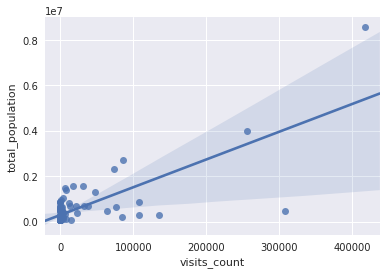

In [64]:
visits_per_pop = sns.regplot(x="visits_count", y="total_population", data=dest_pop_query_df)

In [65]:
pearson_coef, p_value = stats.pearsonr(dest_pop_query_df['visits_count'], dest_pop_query_df['total_population'])
print("Pearson Correlation Coefficient:", pearson_coef) 
print("P-value:", p_value)

Pearson Correlation Coefficient: 0.752629054624
P-value: 1.73888249152e-19


We can see that because very few visits_count values are above 200,000, while most are well under 100,000, there's a tight clustering at the left of the graph that makes it difficult to see visually whether there might be a correlation. This is where the Pearson Correlation Coefficient comes in. It being between 0.70 and 0.90 tells us that there is a high correlation between the number of visits to a city and the total population of that city. The P-value (`1.73888 x 10^-19`) being so close to 0 tells us the correlation is highly significant (not likely a coincidence). In other words, more populous cities in the United States are indeed more popular travel destinations for leisure.

Further and more sophisticated inquiries can be pursued by data analysts. We know that the data model we created will allow them to investigate links between demographics, temperature and visits to the United States.

### 4.3 Data dictionary 
Data dictionary for our data model.

#### immigrations_dim

| Field | Description |
| --- | --- |
| immigration_id | id of respondent record |
| age | age of respondent |
| gender | gender of respondent |
| citizenship_country | respondent's citizenship country |
| residence_country | respondent's country of residence |
| arrival_date | respondent's arrival date |
| departure_date | respondent's departure date |
| visa_type | type of visa granted to respondent (values: 1 = business, 2 = pleasure, 3 = student) |
| admitted_until | date until which respondent is permitted to stay |
| port_of_entry | respondent's port of entry port code |
| port_city | city denoted by port_of_entry |
| port_state | state denoted by port_of_entry |
| port_country | country denoted by port_of_entry |
| destination_state | state where the respondent intends to stay | 

#### demographics_dim

| Field | Description |
| --- | --- |
| city_id | id of city demographics record |
| port_code | port code associated with this city, if applicable |
| city | the name of the city |
| state | city's state |
| median_age | city's median citizen age |
| male_population | total male population for this city |
| female_population | total female population for this city |
| total_population | total population for this city |
| total_veterans | number of veterans in this city |
| foreign_born | number of residents who are foreign-born |
| avg_household_size | average household size for this city |
| indigenous | number of residents who are American Indian and Alaska Native |
| asian | number of residents who are Asian |
| black | number of residents who are Black or African-American | 
| latinx | number of residents who are Hispanic or Latinx |
| white | number of residents who are White |

#### temperature_dim

| Field | Description |
| --- | --- |
| temperature_id | id of temperature record |
| port_code | port code associated with this temperature record's city, if applicable |
| date | the date of this temperature record |
| avg_temperature | average temperature measured during the month of this temperature record |
| city | the name of the city of this temperature record |
| country | the name of the country of this temperature record |

#### date_dim

| Field | Description |
| --- | --- |
| date | yyyy-MM-dd value; also serves as the id of this date record |
| day | day of month for this date record (numeric value) |
| week | week of year for this date record (numeric value) |
| month | month of year for this date record (numeric value) |
| year | year of this date record |
| weekday | day of week of this date record (numeric value) |

#### visits_fact

| Field | Description |
| --- | --- |
| visit_id | id of visit record |
| immigration_id | references an immigrations_dim id; each record from immigrations_dim represents a visit in visits_fact |
| port_code | port_of_entry for the referenced immigrations_dim record |
| arrival_date | arrival_date for the referenced immigrations_dim record |
| length_of_stay | number of days between arrival_date and departure_date for this visitor's immigrations_dim record |

## Step 5: Discussion

### Tools Rationale

Spark was chosen for this project because of its ability to process large amounts of data in a distributed cluster and the ease with which in can scale. Our source datasets are quite large, and they would be even larger if we were using the complete i94 dataset, rather than limiting ourselves to a single month. The final tables were written out as parquet files, but they could also be loaded into a Redshift cluster. 

### Data updates

The data here represent a moment in time, but if this were a pipeline that was meant to be maintained, with regularly updated data sources, we could update our data at regular intervals. The data update schedule would depend on how often our sources are updated and how vital for our business or research needs it would be to have up to the moment data. The core piece of data in this project is the immigration data, so if it is updated annually, an annual update cycle would make sense. If it is updated monthly, we could update monthly, as long as we understand that some of our other data sources, such as the demographic data (which is extracted from census data), would not be updated as frequently.

### What if...
#### ...the data was increased by 100x?
Then we should make sure to set up the contents of this notebook as a Python script that can be run in an EMR cluster, so that we can scale according to our needs.

#### ... the data populates a dashboard that must be updated on a daily basis by 7am every day?
Then we would really benefit from relying on an automated pipeline scheduler and job runner like Airflow.

#### ...the database needed to be accessed by 100+ people?
Then moving our data to a Redshift cluster hosted in the cloud would allow for scaling as our numbers of users and reads increase.